In [1]:
import torch 
import os 
import numpy as np 
from torchvision import transforms 
from torchvision.datasets import MNIST 
from torchvision import models 

print(os.getcwd())
root = os.getcwd()

/content


In [2]:
batch_size=128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
transformations = transforms.Compose([transforms.Resize((221, 221)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485], std=[0.229])
                                    ])

mnist_data = MNIST(root=r'./MNIST',
                   download=True, train=True,
                   transform=transformations)

data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [4]:
import matplotlib.pyplot as plt 
import numpy as np
import torchvision 

def imshow(img):
  img = torch.permute(img, (1, 2, 0))
  plt.imshow(img)
  plt.show()


images, labels = next(iter(data_loader))

# imshow(torchvision.utils.make_grid(images, nrow=4))


In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 2)
        self.conv2 = nn.Conv2d(8, 16, 2)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, 10)

    def embedding(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print('shape of x after flatten : ', x.shape)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print('shape of x after flatten : ', x.shape)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        x = x/torch.linalg.norm(x)    # extra normalization step 

        x = self.fc5(x)

        return x


net = Net().to(device)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.detach().cpu().item()
        if ((i+1) % 100) == 0:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.325
[1,   200] loss: 2.323
[1,   300] loss: 2.318
[1,   400] loss: 2.316
[2,   100] loss: 2.311
[2,   200] loss: 2.309
[2,   300] loss: 2.308
[2,   400] loss: 2.306
[3,   100] loss: 2.304
[3,   200] loss: 2.304
[3,   300] loss: 2.304
[3,   400] loss: 2.304
[4,   100] loss: 2.302
[4,   200] loss: 2.302
[4,   300] loss: 2.303
[4,   400] loss: 2.303
[5,   100] loss: 2.301
[5,   200] loss: 2.301
[5,   300] loss: 2.302
[5,   400] loss: 2.302
[6,   100] loss: 2.302
[6,   200] loss: 2.301
[6,   300] loss: 2.302
[6,   400] loss: 2.301
[7,   100] loss: 2.302
[7,   200] loss: 2.301
[7,   300] loss: 2.301
[7,   400] loss: 2.301
[8,   100] loss: 2.302
[8,   200] loss: 2.301
[8,   300] loss: 2.301
[8,   400] loss: 2.302
[9,   100] loss: 2.301
[9,   200] loss: 2.301
[9,   300] loss: 2.302
[9,   400] loss: 2.301
[10,   100] loss: 2.301
[10,   200] loss: 2.301
[10,   300] loss: 2.301
[10,   400] loss: 2.300
[11,   100] loss: 2.301
[11,   200] loss: 2.301
[11,   300] loss: 2.301
[11,

In [18]:
path = './mnist_net.pth'
torch.save(net.state_dict(), path)

In [19]:
test_bs = 8
mnist_test_data = MNIST(root=r'./MNIST',
                   download=False, train=False,
                   transform=transformations)
test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=test_bs, shuffle=True)

In [20]:
net = Net().to(device)
net.load_state_dict(torch.load(path))

<All keys matched successfully>

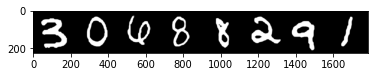

tensor([3, 0, 6, 8, 8, 2, 9, 1])


In [21]:
test_images, test_labels = next(iter(test_loader))

# print images
imshow(torchvision.utils.make_grid(test_images, nrows=test_bs))
print(test_labels)

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device); labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


In [23]:
print(f'Accuracy of the network on the '+ str(total) +' test images: '+ str(100 * correct // total)+ '%')

Accuracy of the network on the 10000 test images: 10%
